# Time-Series Generation and Forecasting

This Notebook explains how to use time-series data to generate new data points and forecast future data points. The [TimeSeriesGenerator](../deeptrade/models/time_series_processes.py) is used to generate data points, there are 3 timeseries provided:

- Gaussian Brownian Motion (GBM)
- Ornstein-Uhlenbeck Process (OU)
- Jump Diffusion Model (JDM)

In [34]:
from deeptrade.models import GBM, OU, JDM
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

COLOURS = [[0, 18, 25], [0, 95, 115], [10, 147, 150], [148, 210, 189], [233, 216, 166], [238, 155, 0], [202, 103, 2], [187, 62, 3], [174, 32, 18], [155, 34, 38]]
COLOURS = [[value/255 for value in rgb] for rgb in COLOURS]

In [35]:
# These parameters apply to all models
seed = 1
dt = 1/252  # measured in years
n_steps = 252*5  # measured in days

## Gaussian Brownian Motion (GBM)

The GBM is a continuous-time stochastic process where the logarithm of an instruments price follows a Brownian motion with drift. The GBM is defined by the stochastic differential equation:

$$
    dS_{t} = \mu S_{t} \, dt + \sigma S_{t} \, dW_{t}
$$

where:
- $S_{t}$ is the price of the instrument at time $t$,
- $\mu$ is the drift of the instrument,
- $\sigma$ is the volatility of the instrument,
- $dW_{t}$ is the Wiener process (or Brownian motion), representing the random component.

For a portfolio of assets the GBM model can be extended to a multivariate setting, accounting for correlations among assets. In this case, the stochastic differential equation for each instrument $i$ is:

$$
    dS_{i, t} = S_{i, t} \Bigl(  \mu_{i} dt + \sum_{j=1}^{n} \Sigma_{ij} dW_{j, t} \Bigr),
$$

where:
- $\mu_{i}$ is the drift of instrument $i$
- $\Sigma_{ij}$ is an element of the volatility matrix $\Sigma$, which encodes both the volatility of instrument $i$, when $i=j$, and the correlation between instrument $i$ and $j$.
- $dW_{j,t}$ is the Brownian motion associated with asset $j$, introducing randomness.

The solution to this system of SDEs, which gives the price of each instrument $i$ at time $t$, is:

$$
    S_{i, t} = S_{i, 0} \exp \left( \left( \mu_i - \frac{1}{2} \sum_{j=1}^n \Sigma_{ij}^2 \right) t + \sum_{j=1}^n \Sigma_{ij} W_{j, t} \right).
$$

In this form:
- $\mu_i - \frac{1}{2} \sum_{j=1}^n \Sigma_{ij}^2$ represents the adjusted drift for instrument $i$, after accounting for the impact of volatility on growth.
- $\sum_{j=1}^n \Sigma_{ij} W_{j, t}$ represents the combined random shocks experienced by instrument $i$, weighted by its volatility and correlations with other instruments.

This formulation allows the model to represent the price evolution of a correlated portfolio, in which each instrument's path is influenced both by its own characteristics and by its interactions with other instruments.

In financial time-series this model is most often used to represent asset prices that grow exponentially over time, this includes:
- *Individual Equities* over short to medium time horizons, e.g. [AAPL](https://uk.finance.yahoo.com/quote/AAPL/), [NVDA](https://uk.finance.yahoo.com/quote/NVDA/), [SHEL](https://uk.finance.yahoo.com/quote/SHEL.L/).
- *Market indices*, e.g. [SPX500](https://uk.finance.yahoo.com/quote/%5ESPX/), [N225](https://uk.finance.yahoo.com/quote/%5EN225/), [FTSE100](https://uk.finance.yahoo.com/quote/%5EFTSE/).

In [36]:
s0 = np.array([120.0, 90.0, 100.0])  # initial prices
mu = np.array([0.8, 0.5, 0.1])  # drift of each asset
cov_matrix = np.diag([0.7, 0.3, 0.05])  # covariance matrix, assuming no correlation

gaussian_process = GBM(s0, mu, cov_matrix, seed)
gdm_prices = gaussian_process.generate(dt, n_steps)

Text(0.5, 0, 'Time')

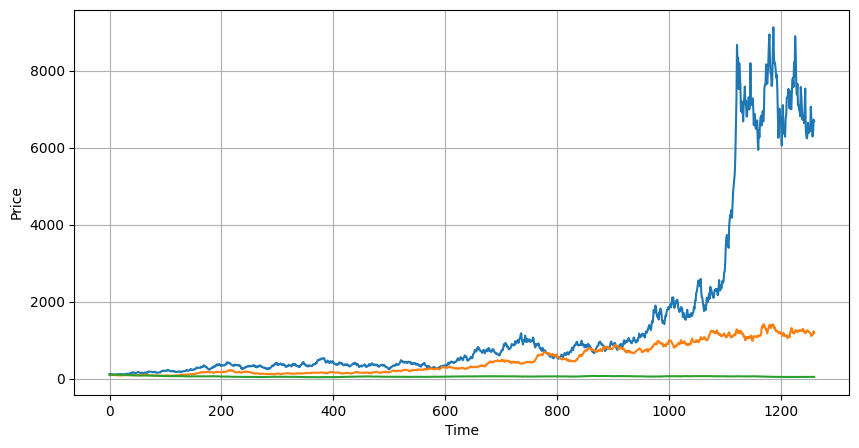

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for idi in range(3):
    ax.plot(gdm_prices[idi, :], label=f"Asset {idi+1}")
ax.grid()
ax.set_ylabel("Price")
ax.set_xlabel("Time")

## Ornstein-Uhlenbeck (OU) Process

The Ornstein-Uhlenbeck (OU) process is a continuous-time stochastic process used to model mean-reverting behavior. In this models case, the mean is not constant but grows over time, making the process adaptable to situations where the long-term average of an instrument's value shifts gradually. The multivariate OU process with a growing mean is generated by iteratively applying the following equation:

$$
    X_{i, t} = X_{i, t-1} + \theta (\mu_t - X_{i, t-1}) \, dt + \sigma \, \text{CorrelatedNoise}_{i, t} \sqrt{dt}, 
$$

where:
- $X_{i, t}$ is the value of instrument $i$ at time $t$,
- $\theta$ is the mean reversion rate, determining how quickly the process reverts towards its mean,
- $\mu_{t}$ is the growing mean at time $t$, calculated as $\mu_{t} = \mu_{0} + \delta t dt$, where $delta$ controls the growth of the instrument,
- $\sigma$ is the instrument's volatility,
- $\text{CorrelatedNoise}_{i, t}$ is the correlated random shocks at time $t$, derived from the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of the correlation matrix.

The OU process can be divided into two components:
- The **mean reversion term**, $\theta (\mu_{t} - X_{i, t-1}) dt$, pulls the process back towards its mean value $\mu_{t}$.
- The **stochastic term**, $\sigma \ \text{CorrelatedNoise}_{i, t} \sqrt{dt}$, adds random fluctuations, adjusting for correlations among assets. 

In financial time-series this model is most often used to represent asset prices that fluctuate around a long-term average or slow growth, this includes:
- *Interest rates*, e.g. [US10Y](https://uk.finance.yahoo.com/quote/%5ETNX/), [UK10Y](https://www.cnbc.com/quotes/UK10Y-GB), [JP10Y](https://www.cnbc.com/quotes/JP10Y-JP).
- *Commodity Prices*, e.g. [Oil](https://uk.finance.yahoo.com/quote/CL=F/), [Silver](https://uk.finance.yahoo.com/quote/SI=F/), [Hogs](https://tradingeconomics.com/commodity/lean-hogs).
- *Foreign Exchange*, e.g. [USDGBP]


In [38]:
s0 = np.array([1.0, 0.9, 1.1])
mu0 = np.array([1.0, 1.1, 1.0])
delta = np.array([0.02, 0.02, 0.025])
theta = np.array([0.1, 0.05, 0.2])
sigma = np.array([0.5, 0.3, 0.05])
corr = np.diag([1.0, 1.0, 1.0])

ou_process = OU(s0, mu0, delta, theta, sigma, corr, seed)
prices = ou_process.generate(dt, n_steps)

Text(0.5, 0, 'Time')

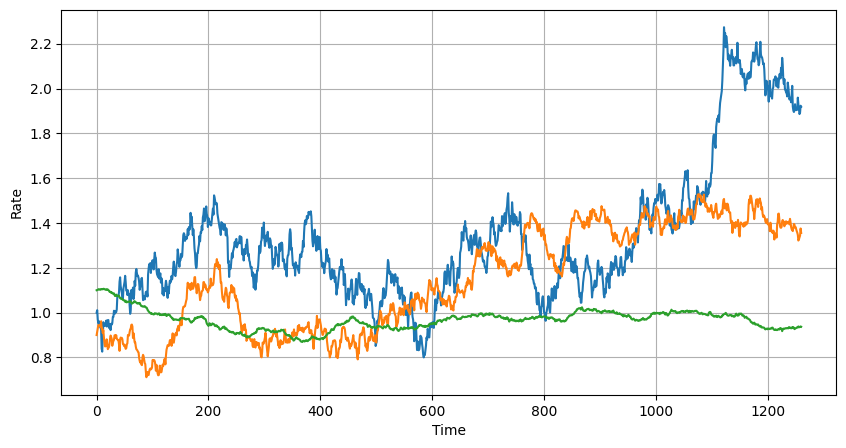

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for idi in range(3):
    ax.plot(prices[idi, :], label=f"Asset {idi+1}")
ax.grid()
ax.set_ylabel("Rate")
ax.set_xlabel("Time")

## Jump Diffusion Model (JDM)

The JDM is a stochastic process that combines continuous price changes, modelled with a GBM, with discrete jumps in price that occur randomly over time. The mulitvariate JDM is defined by the following equation:

$$

dS_{i, t} = S_{i, t} \left( \mu_i \, dt + \sum_{j=1}^n \Sigma_{ij} \, dW_{j, t} \right) + S_{i, t-1} \left( J_{i, t} - 1 \right) dN_{i, t}

$$

where:
- $S_{i, t}$ is the price of instrument $i$ at time $t$,
- $\mu_{i}$ is the drift rate of the instrument,
- $\Sigma_{ij}$  is the volatility matrix derived from the covariance matrix, representing both individual instrument volatilities (when $i = j$) and correlations between assets (when $i \neq j$ ),
- $dW_{j, t}$ is the Brownian motion for asset $j$ , providing correlated random fluctuations,
- $dN_{i, t}$ is a Poisson process with intensity $\lambda_{i}$ , determining the frequency of jumps for instrument $i$,
- $J_{i, t}$  is the jump magnitude for asset $i$ , modeled by a log-normal distribution when a jump occurs.

In this model:

- $S_{i, t} \left( \mu_i \, dt + \sum_{j=1}^n \Sigma_{ij} \, dW_{j, t} \right)$ represents the continuous drift and volatility of each instruments price, from GBM.
- $S_{i, t-1} \left( J_{i, t} - 1 \right) dN_{i, t}$ represents the discrete jumps in price, which occur randomly and are scaled by the previous price of the instrument.

The solution to this system of SDEs, which gives the price of each instrument $i$ at time $t$, is:

$$
    S_{i, t} = S_{i, 0} \exp \left( \left( \mu_i - \frac{1}{2} \sum_{j=1}^n \Sigma_{ij}^2 \right) t + \sum_{j=1}^n \Sigma_{ij} W_{j, t} \right) \prod_{k=1}^{N_{i, t}} J_{i, k} .
$$

Comparing this to the GBM equation the only difference is the product term $\prod_{k=1}^{N_{i, t}} J_{i, k}$ which represents the cumulative effects of all jumps for instrument $i$ up to time $t$, with each $J_{i, k}$ being an independent jump magnitude sampled whenever $dN_{i, t}$ registers a jump.

In financial time-series this model is most often used to represent asset prices that exhibit sudden, discontinuous changes, this usually involves equities or commodities that are subject to news or earnings events or other external shocks, such as earthquakes.


In [40]:
s0 = np.array([120.0, 90.0, 100.0])  # initial prices
mu = np.array([0.8, 0.5, 0.1])  # drift of each asset
cov_matrix = np.diag([0.7, 0.3, 0.05])  # covariance matrix, assuming no correlation
jump_lambda = 0.7  # jump intensity
mu_j = np.array([0.05, 0.1, 0.5])  # mean movement of each jump
sigma_j = np.array([0.1, 0.1, 0.1])  # volatility of each jump

jdm_process = JDM(s0, mu, cov_matrix, jump_lambda, mu_j, sigma_j, seed)
prices = jdm_process.generate(dt, n_steps)

Text(0.5, 0, 'Time')

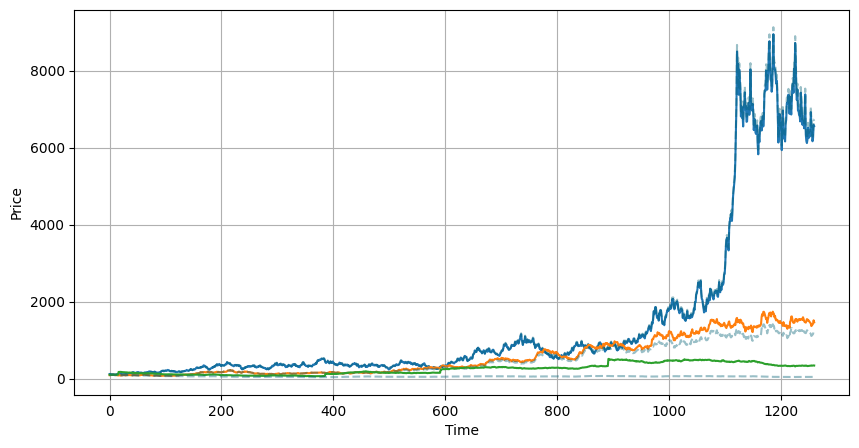

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for idi in range(3):
    ax.plot(prices[idi, :], label=f"Asset {idi+1}")
    ax.plot(gdm_prices[idi, :], label=f"Asset {idi+1} GBM", linestyle="--", alpha=0.4, c=COLOURS[1])
ax.grid()
ax.set_ylabel("Price")
ax.set_xlabel("Time")